In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("robervalt/sunspots")

print("Path to dataset files:", path)

100%|██████████| 22.4k/22.4k [00:00<00:00, 13.1MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/robervalt/sunspots/versions/3


In [3]:
# create dataframe
csv_file_path = f"{path}/Sunspots.csv"
df = pd.read_csv(csv_file_path)

In [4]:
df.shape

(3265, 3)

In [5]:
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [6]:
# define time and series veriable according to dataframe
time = pd.to_datetime(df['Date'])
series = df['Monthly Mean Total Sunspot Number']

# check it
print(time.head())
print(series.head())

0   1749-01-31
1   1749-02-28
2   1749-03-31
3   1749-04-30
4   1749-05-31
Name: Date, dtype: datetime64[ns]
0     96.7
1    104.3
2    116.7
3     92.8
4    141.7
Name: Monthly Mean Total Sunspot Number, dtype: float64


In [7]:
# turn into numpy array
time.to_numpy()
series.to_numpy()

array([ 96.7, 104.3, 116.7, ...,  34. ,  21.8,  10.4])

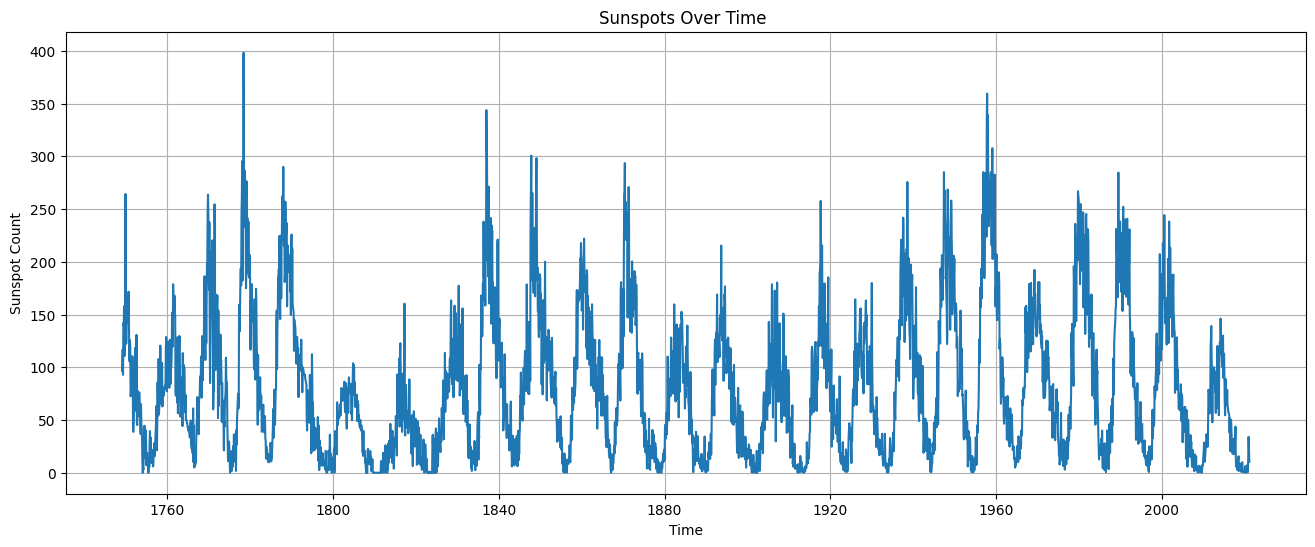

In [8]:
# Draw the garph
plt.figure(figsize=(16, 6))
plt.plot(time, series)
plt.title("Sunspots Over Time ")
plt.xlabel("Time")
plt.ylabel("Sunspot Count")
plt.grid(True)
plt.show()


# Split dataset

In [9]:
df.shape

(3265, 3)

In [10]:
# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

# 2. Windowing dataset

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size)

    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)

    return dataset

# tune window_size and other parameters

In [12]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [13]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# 1. BUILD MODEL WITH NEURAL NETWORKS (DNN)

# 1.1 Model for Laerning Rate Optimization

In [14]:
# Build model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(15, activation="relu"),
    tf.keras.layers.Dense(1, activation = "relu")
])

In [15]:
# save initial weights
init_weights = model.get_weights()

In [16]:
# add callbacks for optimization LR
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [17]:
# Compile model
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(momentum=0.9))

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 71.8143 - learning_rate: 1.0000e-08
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 71.7083 - learning_rate: 1.1220e-08
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 71.5837 - learning_rate: 1.2589e-08
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 71.4407 - learning_rate: 1.4125e-08
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 71.2742 - learning_rate: 1.5849e-08
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 71.0769 - learning_rate: 1.7783e-08
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 70.8396 - learning_rate: 1.9953e-08
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 70.5594 - learning_rate: 2.2387e-08
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 70.2245 - learning_rate: 2.5119e-08
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 69.8136 - learning_rate: 2.8184e-08
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 69.3066 - learning_rate: 3.1623e-08
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

(1e-08, 0.001, 0.0, 100.0)

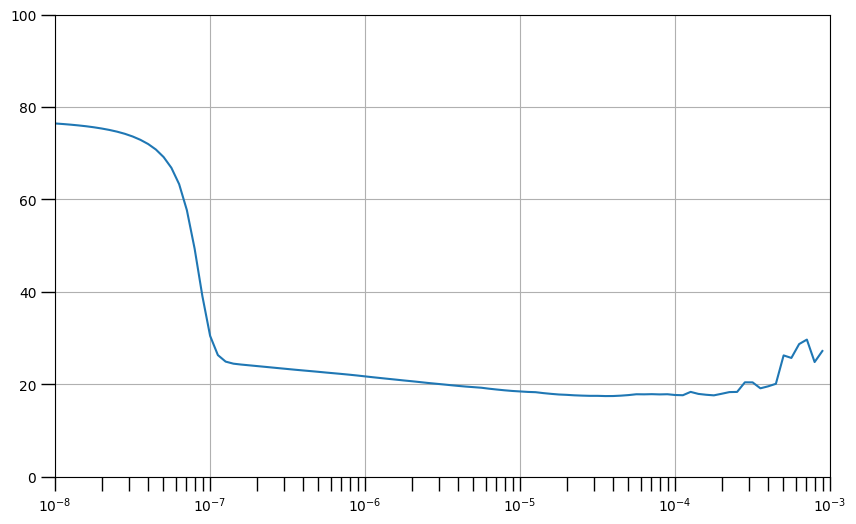

In [18]:
# choose defauld learning rate and see changes in the graph
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# graph
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-3, 0, 100])

# 🧠 Optimum Learning Rate = 2e-5

# Build new model with optimizized learning rate

In [19]:
# Reset weights and veriables:

# reset veriables
tf.keras.backend.clear_session()

# reset weights
model.set_weights(init_weights)


In [20]:
# Build optimized model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(15, activation="relu"),
    tf.keras.layers.Dense(1, activation = "relu")
    ])

In [21]:
# Compile model
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9),
              metrics=["mae"])

# Train the new model
history = model.fit(train_set, epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 29.7164 - mae: 30.2113
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.9909 - mae: 19.4833
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.3474 - mae: 18.8406
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.9404 - mae: 18.4326
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.6312 - mae: 18.1237
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.4225 - mae: 17.9146
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.3107 - mae: 17.8034
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.2499 - mae: 17.7432
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.0598 - mae: 17.5506
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.9918 - mae: 17.4837
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.9111 - mae: 17.4028
Epoch 12/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.8393 - mae: 17.3321
Epoch 13/100


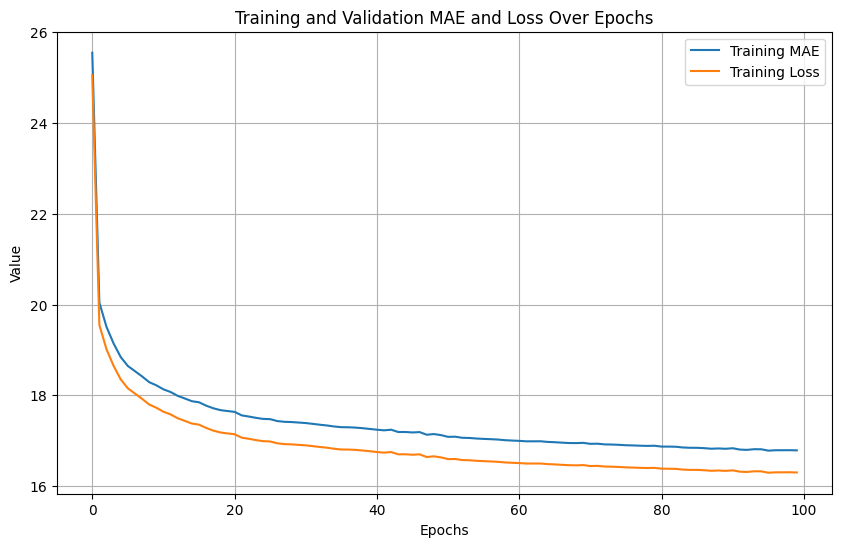

In [22]:
# performans metrics
mae = history.history['mae']
loss = history.history['loss']

# define epochs
epochs = range(len(loss))

# Draw the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, label='Training MAE')
plt.plot(epochs, loss, label='Training Loss')
plt.title('Training and Validation MAE and Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


# Prediction

In [23]:
# the function to draw graphs easily
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):

    plt.figure(figsize=(10, 6))

    if type(y) is tuple:
      for y_curr in y:
        plt.plot(x[start:end], y_curr[start:end], format)
    else:
      plt.plot(x[start:end], y[start:end], format)


    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
      plt.legend(legend)
    plt.title(title)
    plt.grid(True)
    plt.show()

In [24]:
# The function for prediction
def model_forecast(model, series, window_size, batch_size):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset, verbose=0)

    return forecast

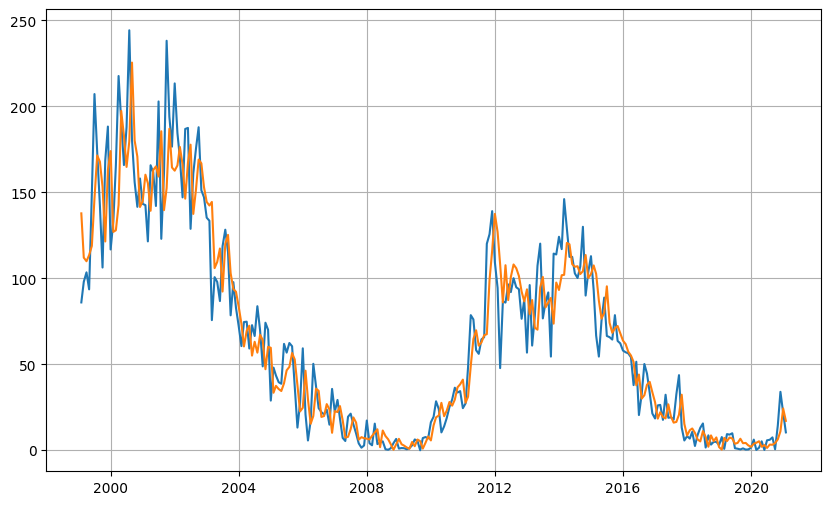

In [25]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)

results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [26]:
# Compute the MAE
print(tf.keras.metrics.mae(x_valid, results).numpy())

14.038267


# 2. MODEL WITH LSTM AND CNN

In [27]:
# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [28]:
# Parameters
window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [29]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [30]:
# Build Model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal'),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

In [31]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

In [32]:
learning_rate = 8e-7

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100)


Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - loss: 57.5432 - mae: 58.0408
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - loss: 22.8337 - mae: 23.3282
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 21.4910 - mae: 21.9830
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - loss: 20.6040 - mae: 21.0978
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 20.1255 - mae: 20.6193
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 19.7090 - mae: 20.2041
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 19.5267 - mae: 20.0196
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 19.3581 - mae: 19.8494
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - loss: 19.3479 - mae: 19.8407
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 19.1590 - mae: 19.6519
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 19.1139 - mae: 19.6061
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 18.9915 - mae: 1

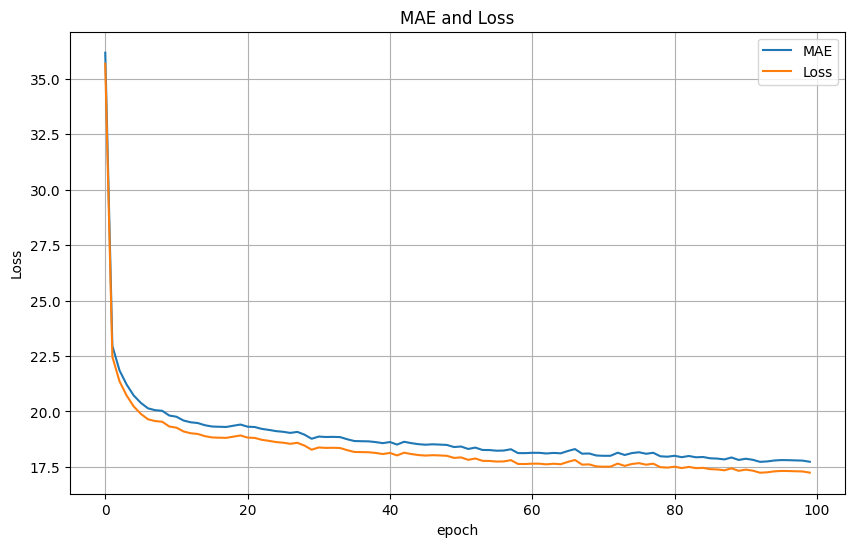

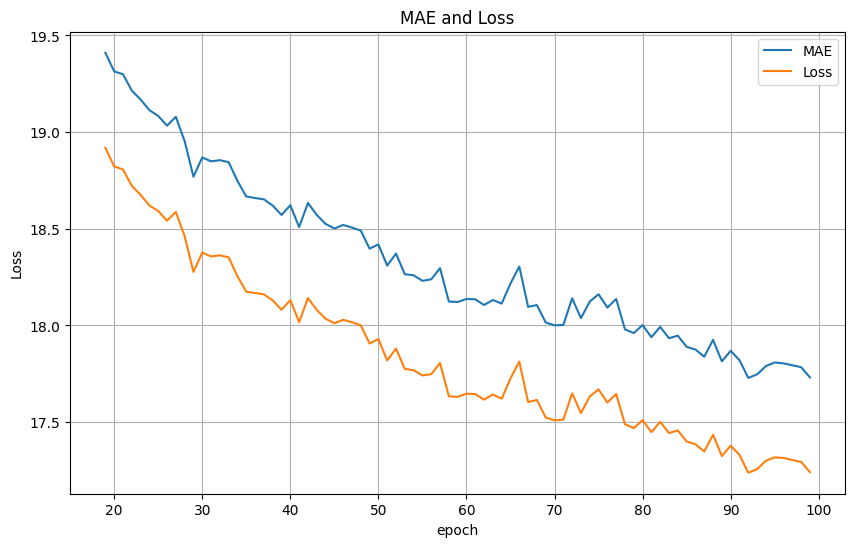

In [33]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Prediction

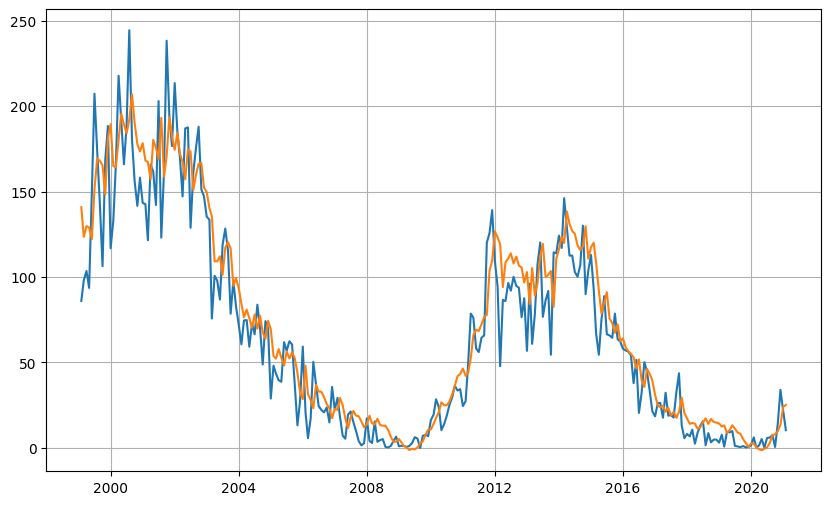

In [34]:
forecast_series = series[split_time-window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)

results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [35]:
# Compute the MAE
print(tf.keras.metrics.mae(x_valid, results).numpy())

14.523124


# 3. PUT EVERYTHING TOGETHER: DNN, LSTM, CNN

In [36]:
# Reset veriables
tf.keras.backend.clear_session()

In [37]:
# Parameters
window_size = 60
batch_size = 250
shuffle_buffer_size = 1000

In [38]:
# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Learning Rate Optimization

# + Optimization:
- I have 3000 data point in train set. I choose numbers for the numbers of neuron and filter, batch_size, window_size which are exactly divisible by this number


In [39]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    #CNN
    tf.keras.layers.Conv1D(filters=60, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu"),
    #LSTM
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),

    #DNN
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),

    #Output Layer
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 60, 60)              │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 60, 60)              │          29,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60)                  │          29,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             310 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,471 (236.21 KB)

 Trainable params: 60,471 (236.21 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Add callbacks for optimization Learning Rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Compile the model. Choos Huber as a loss function which is less sensitive outliers
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics = ["mae"])

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 330ms/step - loss: 80.2251 - mae: 80.7220 - learning_rate: 1.0000e-08
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - loss: 80.0940 - mae: 80.5911 - learning_rate: 1.1220e-08
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - loss: 79.8829 - mae: 80.3803 - learning_rate: 1.2589e-08
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 424ms/step - loss: 79.6303 - mae: 80.1272 - learning_rate: 1.4125e-08
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 293ms/step - loss: 79.3461 - mae: 79.8423 - learning_rate: 1.5849e-08
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 331ms/step - loss: 79.0306 - mae: 79.5266 - learning_rate: 1.7783e-08
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step - loss: 78.6824 - mae: 79.1778 - learning_rate: 1.9953e-08
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 265ms/step - loss: 78.2989 - mae: 78.7951 - learning_rate: 2.2387e-08
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - loss: 77.8756 - mae: 78.3718 - learning_rate: 2.5

(1e-08, 0.001, 0.0, 100.0)

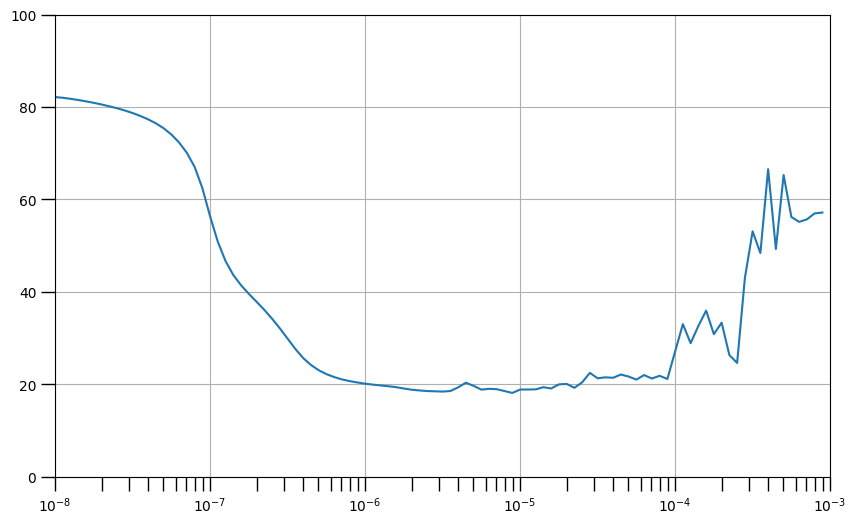

In [45]:
# choose defauld learning rate and see changes in the graph
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# graph
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-3, 0, 100])

# Chosee optimum leraning rate according to graph : 2e-6

# Build Model (DNN-LSTM-CNN) with Optimized LR

In [46]:
# Reset veriables
tf.keras.backend.clear_session()

In [47]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    #CNN
    tf.keras.layers.Conv1D(filters=60, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu"),
    #LSTM
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),

    #DNN
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),

    #Output Layer
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 60, 60)              │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 60, 60)              │          29,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60)                  │          29,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             310 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,471 (236.21 KB)

 Trainable params: 60,471 (236.21 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
learning_rate = 2e-6

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - loss: 58.3798 - mae: 58.8784
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - loss: 31.9344 - mae: 32.4297
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 290ms/step - loss: 27.7547 - mae: 28.2500
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 332ms/step - loss: 26.8049 - mae: 27.3000
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - loss: 24.9549 - mae: 25.4490
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - loss: 23.4685 - mae: 23.9636
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 333ms/step - loss: 22.5655 - mae: 23.0604
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - loss: 22.0206 - mae: 22.5143
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - loss: 21.7047 - mae: 22.1986
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 335ms/step - loss: 21.3440 - mae: 21.8379
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - loss: 21.1305 - mae: 21.6240
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - loss: 20.8720 - mae: 21.3647
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - loss: 20.6350 - mae: 21.1289


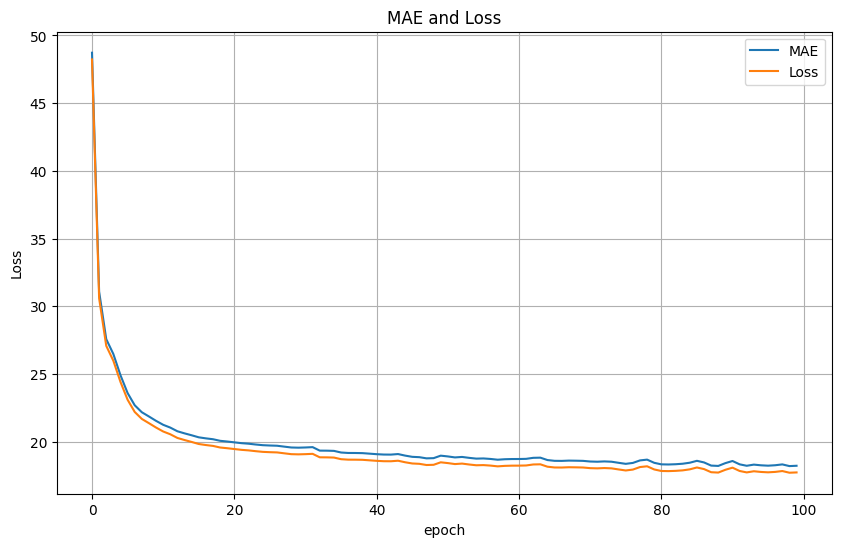

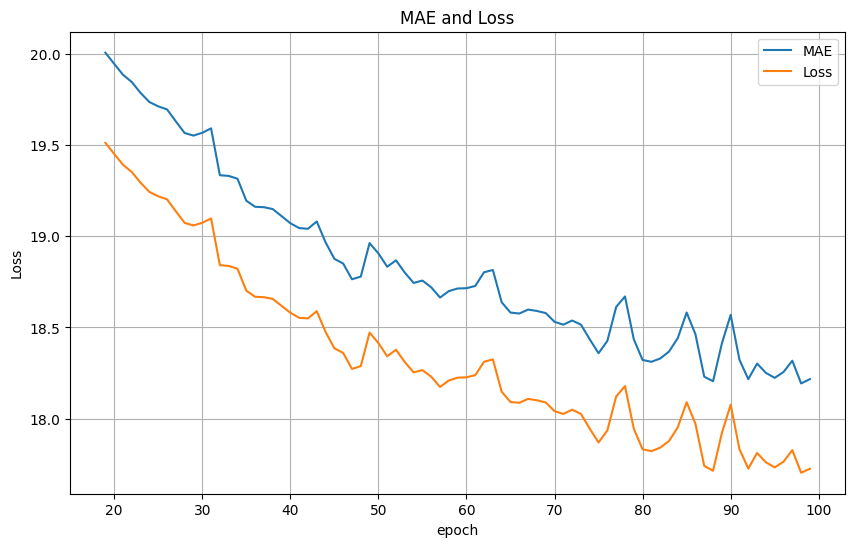

In [49]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

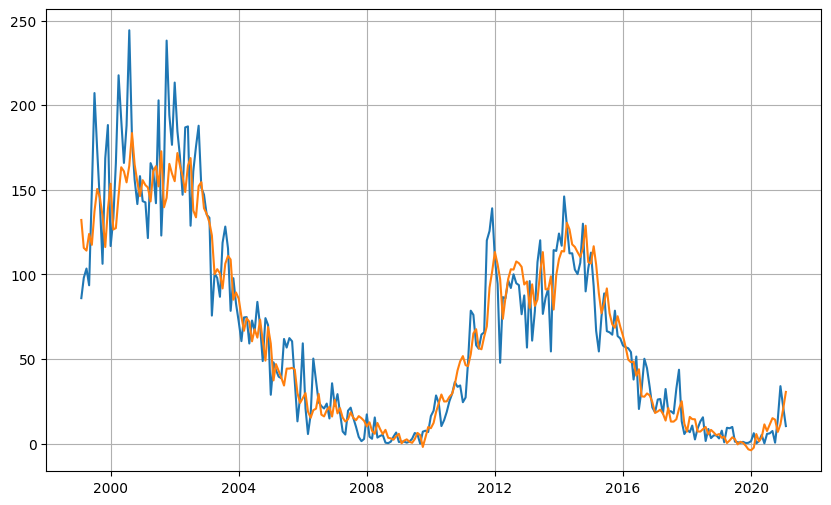

In [50]:
forecast_series = series[split_time-window_size:-1]
forecast = model_forecast(model, forecast_series, window_size, batch_size)

results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [51]:
# Compute the MAE
print(tf.keras.metrics.mae(x_valid, results).numpy())

13.753272
